In [1]:
import pandas as pd
import regex as re
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('log_week_end.csv')
data.rename(columns={'query': 'q'}, inplace=True)

In [3]:
data.sample(5)

,rn,loguser,q
314897,894772,etl_2048,"from tbl_131860,from tbl_131883"
337279,521946,dev_332,"from tbl_7207,from tbl_11022"
401227,83225,etl_1151,from tbl_14641
235828,134609,etl_2048,from tbl_118374
146190,446138,etl_1151,from tbl_15922


In [4]:
data_copy = data.copy()

In [5]:
data.q = data.q.str.lower().str.split(',')

Собираем в списки все команды

In [6]:
intos, froms, joins = [], [], []

In [7]:
'''
выглядит карисивее но выполняется в 42 раза медленне, чем вариант ниже
%%time
for index, row in data.iterrows():
    for x in row.q:
        if 'from' in x:
            froms.append(x)
        if 'into' in x:
            intos.append(x)
        if 'join' in x:
            joins.append(x)
'''

"\nвыглядит карисивее но выполняется в 42 раза медленне, чем вариант ниже\n%%time\nfor index, row in data.iterrows():\n    for x in row.q:\n        if 'from' in x:\n            froms.append(x)\n        if 'into' in x:\n            intos.append(x)\n        if 'join' in x:\n            joins.append(x)\n"

In [8]:
%%time
for x in data.q:
    for g in x:
        if 'join' in g:
            joins.append(g)
        if 'into' in g:
            intos.append(g)
            
for x in data[data.loguser.str.contains('dev')].q:
    for g in x:
        if 'from' in g:
            froms.append(g)

Wall time: 664 ms


Оставляем только название таблиц

In [9]:
intos_tbs = [re.search('tbl_\d*', x).group(0) for x in intos]
froms_tbs = [re.search('tbl_\d*', x).group(0) for x in froms]
joins_tbs = [re.search('tbl_\d*', x).group(0) for x in joins]

Делаем датафрейм с количество from (from только от пользователей dev) при помощи функции `create_df`

In [10]:
def create_df(input_data, column):
    df = pd.DataFrame(data = input_data, columns=['col']).groupby('col').agg({'col': 'count'})
    df.columns= [column]
    df.reset_index(inplace=True)
    return df

In [11]:
df1 = create_df(froms_tbs, 'count_froms')

**Делаем дф с кол-ом join**

In [12]:
df3 = create_df(joins_tbs, 'count_joins')

Объединим join и from при помощи `merge_df`:

In [13]:
def merge_df(data1, data2):
    data = data1.merge(data2, on ='col', how='outer')
    data = data.fillna(0)
    return data

In [14]:
df1 = merge_df(df1,df3)
df1.head()

,col,count_froms,count_joins
0,tbl_100371,4.0,0.0
1,tbl_100498,2.0,0.0
2,tbl_100584,2.0,11.0
3,tbl_100776,1.0,0.0
4,tbl_10080,8.0,13.0


**Делаем дф с кол-ом into**

In [15]:
df2 = create_df(intos_tbs, 'count_intos')
df = merge_df(df1,df2)
df.count_intos = df.count_intos + 1
df['useless'] = df['count_intos'] / df['count_froms']
df.fillna(0, inplace=True)
df.head()

,col,count_froms,count_joins,count_intos,useless
0,tbl_100371,4.0,0.0,1.0,0.250
1,tbl_100498,2.0,0.0,1.0,0.500
2,tbl_100584,2.0,11.0,11.0,5.500
3,tbl_100776,1.0,0.0,1.0,1.000
4,tbl_10080,8.0,13.0,1.0,0.125


In [16]:
pd.set_option('mode.use_inf_as_na', True) #включаем опцию, где inf (бесконечность) считаем как NaN
#предлагаю удалить 

# Если мы это удалим, то в ТОП-10 бесполезных таблиц вылезут таблицы с inf (+бесконечность), где count_froms = 0. 
# попробуйте запустить ТОП-10 без этой ячейки. Ниже вариант с включенной опцией

In [17]:
# ТОП-10 бесполезных таблиц
df.sort_values(by = 'useless', ascending = False, inplace = True)
df.head(10)

,col,count_froms,count_joins,count_intos,useless
1463,tbl_211513,8.0,1.0,9594.0,1199.250000
1692,tbl_29455,1.0,1595.0,471.0,471.000000
1636,tbl_26776,1.0,3083.0,469.0,469.000000
1644,tbl_27182,1.0,8208.0,465.0,465.000000
1462,tbl_211512,21.0,0.0,3139.0,149.476190
652,tbl_15647,2.0,0.0,203.0,101.500000
1919,tbl_44933,10.0,0.0,881.0,88.100000
1520,tbl_23594,1.0,0.0,54.0,54.000000
1466,tbl_211522,32.0,0.0,1171.0,36.593750
1548,tbl_23770,12.0,0.0,325.0,27.083333


## Распределение пользователей по кол-ву запросов

In [18]:
# сгруппируем по пользователям
data_users = data.groupby('loguser').agg({'rn':'nunique'}).sort_values('rn', ascending=False).reset_index()
data_users= data_users.rename(columns={'rn':'count_rn'})
data_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128 entries, 0 to 127
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   loguser   128 non-null    object
 1   count_rn  128 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.1+ KB


In [19]:
# разделим пользователей
etl_users = data_users[data_users['loguser'].str.startswith('etl')]
dev_users = data_users[data_users['loguser'].str.startswith('dev')]

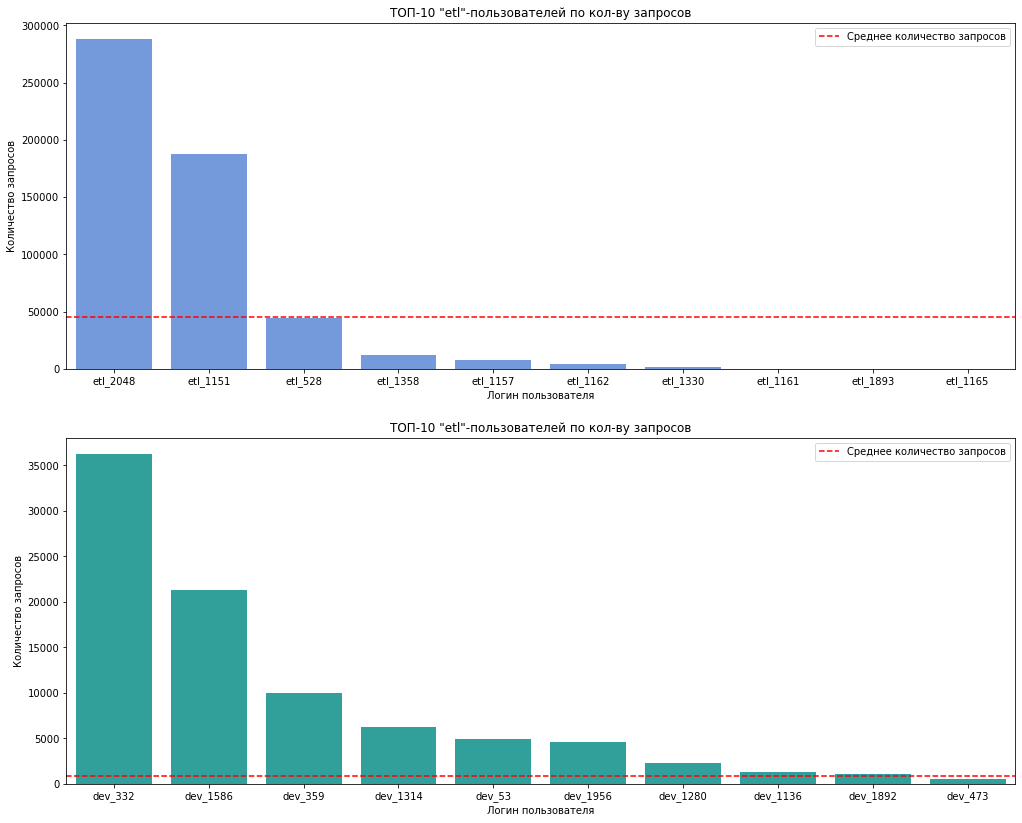

In [58]:
plt.figure(figsize=(17, 14)) #TОП-10 кол-ва запросов для etl/dev

ax1 = plt.subplot(2, 1, 1)
ax1 = sns.barplot(data = etl_users.head(10), x = 'loguser', y = 'count_rn', color = 'cornflowerblue')
ax1.set_title('ТОП-10 "etl"-пользователей по количеству запросов')
ax1.set_xlabel('Логин пользователя')
ax1.set_ylabel('Количество запросов')
plt.axhline(y=etl_users['count_rn'].mean(), label = 'Среднее количество запросов', color ="red", linestyle ="--")
plt.legend()

ax2 = plt.subplot(2, 1, 2)
ax2 = sns.barplot(data = dev_users.head(10), x = 'loguser', y = 'count_rn', color = 'lightseagreen')
ax2.set_title('ТОП-10 "dev"-пользователей по количеству запросов')
ax2.set_xlabel('Логин пользователя')
ax2.set_ylabel('Количество запросов')
plt.axhline(y=dev_users['count_rn'].mean(), label = 'Среднее количество запросов', color ="red", linestyle ="--")
plt.legend()
plt.show()

## Распределение по количеству действий в запросе

In [59]:
# разделим значения в запросах по запятой и сгруппируем по пользователю
#data_copy['count_q'] = data_copy['q'].str.split(',').count()
data_copy['count_q'] = data_copy['q'].apply(lambda x: x.split(","))
data_count_q = data_copy.explode('count_q')
df_exp = data_count_q.copy()
data_count_q = data_count_q.groupby('loguser').agg({'count_q':'count'}).sort_values('count_q', ascending=False).reset_index()
data_count_q.head()

,loguser,count_q
0,etl_1151,805229
1,etl_2048,433093
2,dev_332,72042
3,etl_528,52127
4,etl_1358,23597


In [60]:
# разделим пользователей
etl_count_q = data_count_q[data_count_q['loguser'].str.startswith('etl')]
dev_count_q = data_count_q[data_count_q['loguser'].str.startswith('dev')]

In [62]:
dev_count_q.head()

,loguser,count_q
2,dev_332,72042
5,dev_359,23087
6,dev_1586,22534
8,dev_1280,6804
10,dev_1314,6603


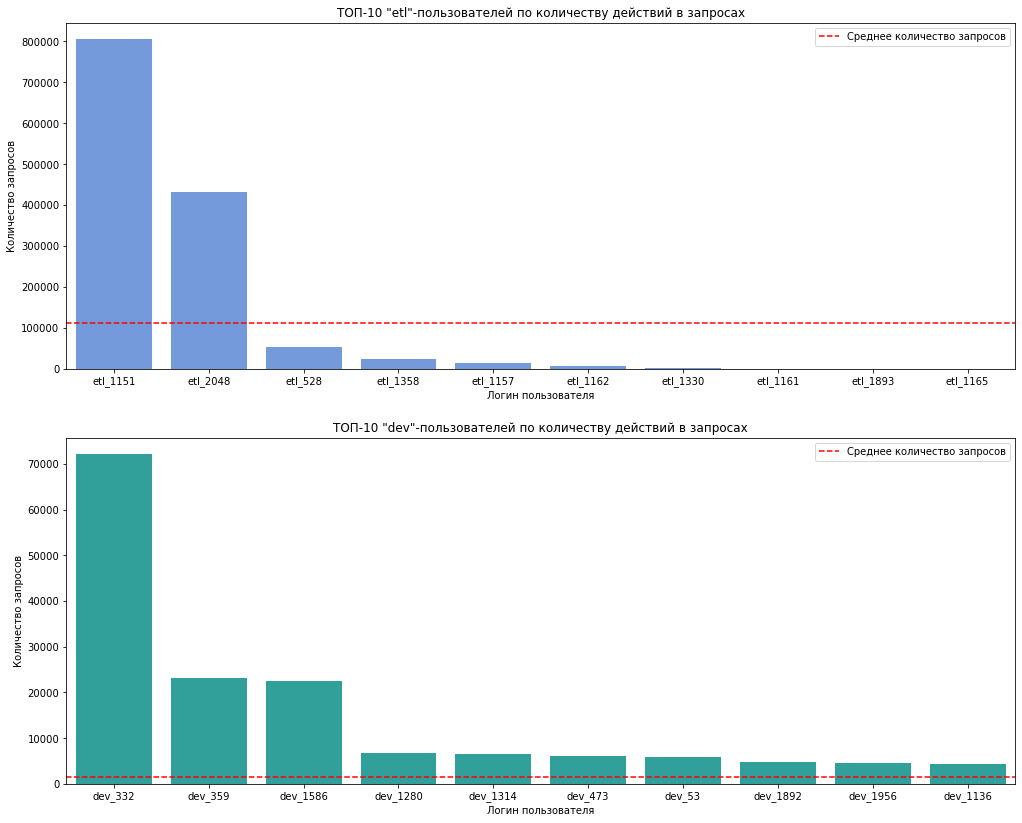

In [64]:
plt.figure(figsize=(17, 14)) #TОП-10 кол-ва действий для etl/dev

ax1 = plt.subplot(2, 1, 1)
ax1 = sns.barplot(data = etl_count_q.head(10), x = 'loguser', y = 'count_q', color = 'cornflowerblue')
ax1.set_title('ТОП-10 "etl"-пользователей по количеству действий в запросах')
ax1.set_xlabel('Логин пользователя')
ax1.set_ylabel('Количество запросов')
plt.axhline(y=etl_count_q['count_q'].mean(), label = 'Среднее количество запросов', color ="red", linestyle ="--")
plt.legend()

ax2 = plt.subplot(2, 1, 2)
ax2 = sns.barplot(data = dev_count_q.head(10), x = 'loguser', y = 'count_q', color = 'lightseagreen')
ax2.set_title('ТОП-10 "dev"-пользователей по количеству действий в запросах')
ax2.set_xlabel('Логин пользователя')
ax2.set_ylabel('Количество запросов')
plt.axhline(y=dev_count_q['count_q'].mean(), label = 'Среднее количество запросов', color ="red", linestyle ="--")
plt.legend()
plt.show()

## Датафрейм - пользователь/таблица/кол-во запросов

In [26]:
df_exp = df_exp.groupby(['loguser','count_q']).agg({'count_q':'count'}).rename(columns={'count_q':'q'})
df_exp = df_exp.reset_index()
df_exp['tab'] = [re.search('tbl_\d*', x).group(0) for x in df_exp['count_q']]
df_exp = df_exp[['loguser', 'q', 'tab']]
df_exp = df_exp.rename(columns={'q':'count'}).sort_values('count', ascending=False)

In [27]:
df_exp.head()

,loguser,count,tab
2690,dev_332,27247,tbl_7207
2611,dev_332,27242,tbl_11022
60963,etl_1358,11262,tbl_33595
60958,etl_1358,11256,tbl_33623
1272,dev_1586,9593,tbl_211513
